In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May 18 15:37:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os, shutil

sys.path.append('/usr/local/lib/python3.7/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ["CONDA_PREFIX"] = "/usr/local"
for so in ['cudf', 'rmm', 'nccl', 'cuml', 'cugraph', 'xgboost', 'cuspatial']:
  fn = 'lib'+so+'.so'
  source_fn = '/usr/local/lib/'+fn
  dest_fn = '/usr/lib/'+fn
  if os.path.exists(source_fn):
    print(f'Copying {source_fn} to {dest_fn}')
    shutil.copyfile(source_fn, dest_fn)
# fix for BlazingSQL import issue
# ImportError: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by /usr/local/lib/python3.7/site-packages/../../libblazingsql-engine.so)
if not os.path.exists('/usr/lib64'):
    os.makedirs('/usr/lib64')
for so_file in os.listdir('/usr/local/lib'):
  if 'libstdc' in so_file:
    shutil.copyfile('/usr/local/lib/'+so_file, '/usr/lib64/'+so_file)
    shutil.copyfile('/usr/local/lib/'+so_file, '/usr/lib/x86_64-linux-gnu/'+so_file)

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 238 (delta 36), reused 11 (delta 5), pack-reused 171
Receiving objects: 100% (238/238), 73.89 KiB | 453.00 KiB/s, done.
Resolving deltas: 100% (98/98), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.19 and 0.20)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.19

	import sys, os, shutil

	sys.path.append('/usr/local/lib/python3.7/site-packages/')
	os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
	os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
	os.environ['CONDA_PREFIX'] = '/usr/local'
	for so in ['cudf', 'rmm'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import cudf
path_1="/content/test.csv"
path_2="/content/train.csv"
test_df = cudf.read_csv(path_1)
train_df = cudf.read_csv(path_2)

In [8]:
train_df.keys()

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [9]:
x = train_df.drop(labels = ["label"], axis=1)

In [10]:
y=train_df['label']

In [11]:
import cuml
from cuml.model_selection import train_test_split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=42)



In [14]:
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

In [15]:
in_shape = x_train.shape[1:]
print(in_shape)

(28, 28, 1)


In [16]:

from cuml.metrics import confusion_matrix
from cuml.metrics.accuracy import accuracy_score
from cuml.neighbors import KNeighborsClassifier
score=[]
for k in range (1,9):
    classifier =  KNeighborsClassifier(n_neighbors=k)
    classifier = classifier.fit(x_train.reshape(x_train.shape[0], 28*28), y_train)
    pred = classifier.predict(x_test.reshape(x_test.shape[0], 28*28))
    accuracy = accuracy_score(y_test, pred)
    score.append(accuracy)
    print("Accuracy: ",accuracy)
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
    print("\n---------------\n")

Accuracy:  0.965238094329834
Confusion Matrix:
      0    1    2    3    4    5    6    7    8    9
0  807    0    2    0    0    0    3    0    1    0
1    0  988    1    1    2    1    0    1    0    0
2    7    7  799    5    0    2    1   20    3    0
3    0    1    5  819    0   16    0    6   12    4
4    0    4    0    0  776    0    4    5    0   10
5    4    1    1   13    2  713   11    2    2    3
6    4    4    0    0    2    1  809    0    0    0
7    0    3    2    1    3    0    0  845    0   10
8    2    7    2   13    1   12    3    6  762   10
9    1    2    0    9    8    2    0   19    2  790

---------------

Accuracy:  0.9592857360839844
Confusion Matrix:
      0    1    2    3    4    5    6    7    8    9
0  811    0    1    0    0    0    1    0    0    0
1    0  990    1    0    2    0    0    1    0    0
2    9    9  811    1    0    0    0   13    1    0
3    3    3    8  835    0    2    0    6    4    2
4    1    9    0    0  780    1    2    2    0    4
5

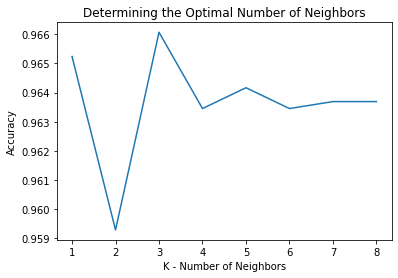

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.plot(range(1,9), score)
plt.title('Determining the Optimal Number of Neighbors')
plt.xlabel('K - Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [18]:


classifier =  KNeighborsClassifier(n_neighbors=3)
classifier = classifier.fit(x_train.reshape(x_train.shape[0], 28*28), y_train)
pred = classifier.predict(x_test.reshape(x_test.shape[0], 28*28))
accuracy = accuracy_score(y_test, pred)
print(accuracy)
    

0.9660714268684387


In [19]:
X = test_df 
X = X.values.reshape(-1,28,28,1)



In [20]:
in_shape = X.shape[1:]
print(in_shape)


(28, 28, 1)


In [21]:
classifier =  KNeighborsClassifier(n_neighbors=3)
classifier = classifier.fit(x_train.reshape(x_train.shape[0], 28*28), y_train)
new=classifier.predict(X.reshape(X.shape[0], 28*28))

In [23]:
label= new

In [24]:
print(label)

[2 0 9 ... 3 9 2]


In [26]:
import cudf as cf
index = test_df.index.values + 1
data = {'ImageId' : index, "Label" : label}
df = cf.DataFrame(data=data)
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [27]:
submit_file = cf.DataFrame({'ImageId' : index, "Label" : label.astype(int).ravel()})


In [29]:
submit_file.to_csv("/content/submission.csv",index = False)

In [28]:
submit_file

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
